In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve , roc_auc_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras

In [98]:
df = pd.read_csv('Bank_Churn_Dataset.csv')
print(df.shape)
df.sample(10)

(10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
2174,15633108,646,France,Male,26,4,139848.17,1,1,0,164696.27,0
6205,15616221,497,France,Female,29,4,85646.81,1,0,0,63233.02,1
5028,15761168,478,France,Female,38,4,171913.87,1,1,0,51820.87,1
4617,15799932,812,France,Male,24,10,0.00,2,1,1,156906.15,0
3040,15617134,716,France,Male,38,4,0.00,2,1,0,189678.70,0
3009,15660200,551,France,Male,31,1,0.00,2,1,1,185105.44,0
5932,15749300,556,France,Female,47,2,139914.27,1,1,1,50390.98,0
6652,15714380,827,France,Male,38,5,0.00,2,0,0,103305.01,0
1473,15594862,552,France,Male,36,8,0.00,2,0,0,132547.02,0
933,15737795,512,Spain,Male,36,1,0.00,1,0,1,135482.26,1


### Data Preprocessing

In [99]:
df.drop('customer_id' , axis=1 , inplace=True)

In [100]:
#Apply one-hot encoding to Categorical Features
df2 = pd.get_dummies(data=df, columns=['country','gender'] , dtype=int)

In [101]:
#Feature Scaling
col_to_scale = ['credit_score','tenure','balance','products_number','age','estimated_salary']
scaler = MinMaxScaler()
df2[col_to_scale] = scaler.fit_transform(df2[col_to_scale])
df2.sample(10)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
6632,0.688,0.175676,0.5,0.000000,0.000000,1,0,0.177925,0,0,0,1,0,1
9302,0.788,0.243243,1.0,0.000000,0.333333,1,1,0.914369,0,1,0,0,0,1
6176,0.516,0.270270,0.8,0.413130,0.333333,1,1,0.685407,0,0,1,0,1,0
8357,0.602,0.216216,0.3,0.000000,0.333333,1,1,0.527991,0,1,0,0,0,1
8215,0.674,0.581081,0.7,0.321001,0.000000,1,0,0.656532,1,1,0,0,1,0
4056,0.610,0.135135,0.3,0.453618,0.333333,0,1,0.384200,0,0,0,1,1,0
5094,0.520,0.256757,0.0,0.000000,0.000000,1,0,0.572570,0,1,0,0,0,1
7391,0.160,0.175676,0.5,0.000000,0.000000,1,0,0.478264,0,1,0,0,0,1
2150,0.636,0.270270,1.0,0.346666,0.000000,0,1,0.185434,0,1,0,0,0,1
2123,0.602,0.094595,0.2,0.435137,0.333333,1,0,0.572829,0,0,1,0,1,0


In [102]:
#Features and Target variable
x = df2.drop('churn',axis=1)
y = df2['churn']

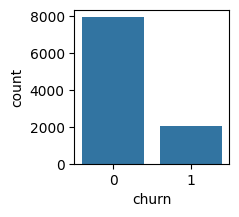

In [103]:
#Distribution of the target variable
plt.figure(figsize=(2,2))
sns.countplot(x='churn' , data = df)
plt.show()

In [104]:
#Split the Dataset for Training and Testing 
x_train, x_rem, y_train, y_rem = train_test_split(x,y, test_size=0.4, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_rem,y_rem, test_size=0.5, random_state=42, stratify=y_rem)

print(f'x_train shape:{x_train.shape}, y_ shape:{y_train.shape}')
print(f'x_val shape:{x_val.shape} , y_val shape:{y_val.shape}')
print(f'x_test shape:{x_test.shape} , y_test shape:{y_test.shape}')

x_train shape:(6000, 13), y_ shape:(6000,)
x_val shape:(2000, 13) , y_val shape:(2000,)
x_test shape:(2000, 13) , y_test shape:(2000,)


In [105]:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64
churn
0    0.796333
1    0.203667
Name: proportion, dtype: float64
churn
0    0.796
1    0.204
Name: proportion, dtype: float64
churn
0    0.7965
1    0.2035
Name: proportion, dtype: float64


In [106]:
#Apply oversampling to the minority class using Synthetic Minority Over-sampling Technique (SMOTE)
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(x_train, y_train)
y_sm.value_counts(normalize=True)

churn
0    0.5
1    0.5
Name: proportion, dtype: float64

## ANN Model 

In [107]:
model = keras.Sequential([
    keras.layers.Input(shape=(13,)), 
    keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x = x_sm, y = y_sm,
          validation_data = (x_val,y_val),
          epochs=100,
          callbacks=[early_stopping]) 

Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.5442 - loss: 1.3553 - val_accuracy: 0.3555 - val_loss: 1.2185
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.5977 - loss: 1.0457 - val_accuracy: 0.5440 - val_loss: 0.9807
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6513 - loss: 0.9010 - val_accuracy: 0.5490 - val_loss: 0.9024
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6761 - loss: 0.7999 - val_accuracy: 0.5970 - val_loss: 0.8026
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6885 - loss: 0.7368 - val_accuracy: 0.7350 - val_loss: 0.6394
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6968 - loss: 0.6800 - val_accuracy: 0.7405 - val_loss: 0.5996
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.7127 - loss: 0.6420 - val_accuracy: 0.7035 - val_loss: 0.6063
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7210 - loss: 0

In [108]:
y_prob = model.predict(x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


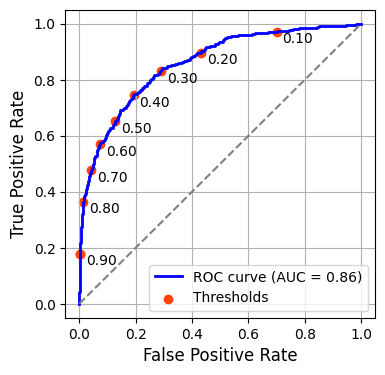

In [177]:
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  

threshold_to_display = np.arange(0.1, 1, 0.1)
threshold_index = [np.abs(threshold - t).argmin() for t in np.arange(0.1, 0.9, 0.1)]
for th in threshold_to_display:
    idx = np.abs(threshold - th).argmin()
    plt.scatter(fpr[idx], tpr[idx], color='orangered')
    plt.text(fpr[idx]+0.02, tpr[idx]-0.04, f'{threshold[idx]:.2f}', fontsize=10)

plt.scatter(fpr[idx], tpr[idx], color='orangered', label='Thresholds')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.57      0.65      0.60       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000



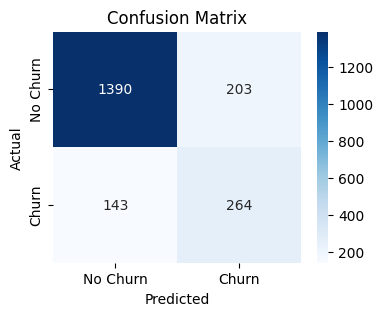

In [119]:
y_pred = (y_prob >= 0.5).astype(int)

class_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", class_rep)

conf_mat = confusion_matrix(y_test , y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [112]:
import pickle
with open('model_v3.pickle' , 'wb') as f:
    pickle.dump(model , f)